<h1><center>Cruise Reviews - Trip Advisor - Models</center></h1>

![title](Screen.png)

## Importing Libraries & Defining functions

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
from datetime import datetime
from scipy import sparse


# Preprocessing
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Assestment
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

#Models
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
#Add settings for SNS

In [2]:
def save_pickle(element,file):
    with open(file, 'wb') as handle:
        pickle.dump(element, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

## Loading Data

In [3]:
# Reviews Content
reviews = pd.read_csv('reviews_step_5.csv', index_col=0)

In [4]:
word_type_df = load_pickle('word_type.pkl')

## Assesing Models

### Model Scorer

In [19]:
# Resetting results
model_results = {}

In [20]:
## pre-setting random state
random_state = 14

##Estimating Baseline
baseline = reviews.stars_grouped.value_counts(normalize = True)[0]



def grid(model_name,model_type,param_dict,Xtr,ytr,Xte,yte,scoring='roc_auc'):
    
    start = datetime.now()
    
    #Fitting grid
    grid = GridSearchCV(model_type,param_dict,n_jobs = -1,scoring=scoring,verbose =2,cv = 5).fit(Xtr,ytr)
    grid_time = datetime.now()
    print('Time\nGrid fitting took {}'.format(grid_time - start))
    
    #Extracting best model and predictions
    model = grid.best_estimator_
    yte_hat = model.predict(Xte)
    
    # binarising for roc_auc
    yte_bin = label_binarize(yte, classes=['Good Review','Bad Review'])
    yte_hat_bin = label_binarize(yte_hat, classes=['Good Review','Bad Review'])
    
    # cross validating for accuracy
    scores = cross_val_score(model,Xtr,ytr,cv = 5,scoring = 'accuracy')
    cv_time = datetime.now()
    print('CV took {}'.format(cv_time - grid_time))

    # additional calculations
    fpr, tpr, threshold = roc_curve(yte_bin, yte_hat_bin,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    # storing results  
    model_results[model_name] = {
        'model': model,
        'accuracy train' : model.score(Xtr,ytr),
        'accuracy test' : model.score(Xte,yte),
        'accuracy cv' : np.mean(scores),
        'confusion' : confusion_matrix(yte,yte_hat,model.classes_),
        'report': classification_report(yte,yte_hat, labels = model.classes_),
        'precision': precision_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
        'recall': recall_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
         'AUC': roc_auc,
         'AUC CV':grid.best_score_
    }    

    #printing results
    print('\nModel Scores')
    print('Accuracy on train data: {}'.format(model_results[model_name]['accuracy train']))
    print('Accuracy on test data: {}'.format(model_results[model_name]['accuracy test']))
    print('Accuracy on CV: {}'.format(model_results[model_name]['accuracy cv']))
    print('Baseline: {}\n'.format(baseline))
    
    print('AUC CV: {}'.format(model_results[model_name]['AUC CV'])) 
    print('\nConfusion Matrix')
    print(model_results[model_name]['confusion'])    
    print('\nClassification Report')
    print(model_results[model_name]['report'])
    
    print('Best Estimator Parameters'.format(model_name))
    print(model.get_params())
    finish = datetime.now()
    return grid

## Different Log Reg Versions

In [21]:
Cs = 10

### Bag of words - Adj - 0%

In [22]:
#Settings
name = 'BOW - ADJ 0% - LogReg'
per = 0
with_mean = False

#X with adj only
adj_X = word_type_df.apply(lambda x: x['ADJ'], axis = 1)

#Defining target
adj_y = reviews.stars_grouped

#Train_Test
adj_Xtrain, adj_Xtest,adj_ytrain, adj_ytest = train_test_split(adj_X,adj_y,test_size = 0.3, stratify = adj_y, random_state = 14)

#TFID vectoriser
adj_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),stop_words = 'english',max_df=0.5, min_df=per)
adj_train_matrix = adj_tvec.fit_transform(adj_Xtrain)
adj_test_matrix = adj_tvec.transform(adj_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
adj_Xtrain_std = scaler.fit_transform(adj_train_matrix)
adj_Xtest_std = scaler.transform(adj_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    adj_Xtrain_std,adj_ytrain,
    adj_Xtest_std,adj_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   19.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.9s finished


Time
Grid fitting took 0:00:33.684793
CV took 0:00:49.796678

Model Scores
Accuracy on train data: 0.9373232097662647
Accuracy on test data: 0.8211184439041334
Accuracy on CV: 0.8280482129560685
Baseline: 0.6779908295122968

AUC CV: 0.892520096438924

Confusion Matrix
[[ 572  355]
 [ 160 1792]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.78      0.62      0.69       927
 Good Review       0.83      0.92      0.87      1952

    accuracy                           0.82      2879
   macro avg       0.81      0.77      0.78      2879
weighted avg       0.82      0.82      0.81      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Adj - 2%

In [23]:
#Settings
name = 'BOW - ADJ 2% - LogReg'
per = 0.02
with_mean = False

#X with adj only
adj_X = word_type_df.apply(lambda x: x['ADJ'], axis = 1)

#Defining target
adj_y = reviews.stars_grouped

#Train_Test
adj_Xtrain, adj_Xtest,adj_ytrain, adj_ytest = train_test_split(adj_X,adj_y,test_size = 0.3, stratify = adj_y,
                                                               random_state = random_state)

#TFID vectoriser
adj_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per)
adj_train_matrix = adj_tvec.fit_transform(adj_Xtrain)
adj_test_matrix = adj_tvec.transform(adj_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
adj_Xtrain_std = scaler.fit_transform(adj_train_matrix)
adj_Xtest_std = scaler.transform(adj_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    adj_Xtrain_std,adj_ytrain,
    adj_Xtest_std,adj_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


Time
Grid fitting took 0:00:01.719801
CV took 0:00:02.061007

Model Scores
Accuracy on train data: 0.8354920351347328
Accuracy on test data: 0.8245918721778396
Accuracy on CV: 0.8219434767577918
Baseline: 0.6779908295122968

AUC CV: 0.8800418191956055

Confusion Matrix
[[ 576  351]
 [ 154 1798]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.79      0.62      0.70       927
 Good Review       0.84      0.92      0.88      1952

    accuracy                           0.82      2879
   macro avg       0.81      0.77      0.79      2879
weighted avg       0.82      0.82      0.82      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Nouns - 0%

In [24]:
#Settings
name = 'BOW - NOUN 0% - LR'
per = 0.00
with_mean = False

#X with noun only
noun_X = word_type_df.apply(lambda x: x['NOUN'], axis = 1)

#Defining target
noun_y = reviews.stars_grouped

#Train_Test
noun_Xtrain, noun_Xtest,noun_ytrain, noun_ytest = train_test_split(noun_X,noun_y,test_size = 0.3, stratify = noun_y,
                                                                   random_state = random_state)

#TFID vectoriser
noun_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                            stop_words = 'english',max_df=0.5, min_df=per)
noun_train_matrix = noun_tvec.fit_transform(noun_Xtrain)
noun_test_matrix = noun_tvec.transform(noun_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
noun_Xtrain_std = scaler.fit_transform(noun_train_matrix)
noun_Xtest_std = scaler.transform(noun_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    noun_Xtrain_std,noun_ytrain,
    noun_Xtest_std,noun_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.9s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.9s finished


Time
Grid fitting took 0:00:17.001488
CV took 0:00:08.757150

Model Scores
Accuracy on train data: 0.970522554711925
Accuracy on test data: 0.783605418548107
Accuracy on CV: 0.7792148663262773
Baseline: 0.6779908295122968

AUC CV: 0.8288468183521172

Confusion Matrix
[[ 503  424]
 [ 199 1753]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.72      0.54      0.62       927
 Good Review       0.81      0.90      0.85      1952

    accuracy                           0.78      2879
   macro avg       0.76      0.72      0.73      2879
weighted avg       0.78      0.78      0.77      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Nouns - 2%

In [25]:
name = 'BOW - NOUN 2% - LR'
per = 0.02
with_mean = False

#X with noun only
noun_X = word_type_df.apply(lambda x: x['NOUN'], axis = 1)

#Defining target
noun_y = reviews.stars_grouped

#Train_Test
noun_Xtrain, noun_Xtest,noun_ytrain, noun_ytest = train_test_split(noun_X,noun_y,test_size = 0.3, stratify = noun_y,
                                                                   random_state = random_state)

#TFID vectoriser
noun_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                            stop_words = 'english',max_df=0.5, min_df=per)
noun_train_matrix = noun_tvec.fit_transform(noun_Xtrain)
noun_test_matrix = noun_tvec.transform(noun_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
noun_Xtrain_std = scaler.fit_transform(noun_train_matrix)
noun_Xtest_std = scaler.transform(noun_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    noun_Xtrain_std,noun_ytrain,
    noun_Xtest_std,noun_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Time
Grid fitting took 0:00:04.960221
CV took 0:00:04.629904

Model Scores
Accuracy on train data: 0.7851719517641804
Accuracy on test data: 0.7537339353942341
Accuracy on CV: 0.7595643637201717
Baseline: 0.6779908295122968

AUC CV: 0.7931115357988665

Confusion Matrix
[[ 405  522]
 [ 187 1765]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.68      0.44      0.53       927
 Good Review       0.77      0.90      0.83      1952

    accuracy                           0.75      2879
   macro avg       0.73      0.67      0.68      2879
weighted avg       0.74      0.75      0.74      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Verbs - 0%

In [26]:
name = 'BOW - VERB 0% - LR'
per = 0
with_mean = False

#X with verb only
verb_X = word_type_df.apply(lambda x: x['VERB'], axis = 1)

#Defining target
verb_y = reviews.stars_grouped

#Train_Test
verb_Xtrain, verb_Xtest,verb_ytrain, verb_ytest = train_test_split(verb_X,verb_y,test_size = 0.3, stratify = verb_y, random_state = random_state)

#TFID vectoriser
verb_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),stop_words = 'english',max_df=0.5, min_df=per)
verb_train_matrix = verb_tvec.fit_transform(verb_Xtrain)
verb_test_matrix = verb_tvec.transform(verb_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
verb_Xtrain_std = scaler.fit_transform(verb_train_matrix)
verb_Xtest_std = scaler.transform(verb_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    verb_Xtrain_std,verb_ytrain,
    verb_Xtest_std,verb_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished


Time
Grid fitting took 0:02:34.389144
CV took 0:00:09.158313

Model Scores
Accuracy on train data: 0.9423849933005806
Accuracy on test data: 0.7908996179228899
Accuracy on CV: 0.7885957389284828
Baseline: 0.6779908295122968

AUC CV: 0.8360108928905557

Confusion Matrix
[[ 506  421]
 [ 181 1771]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.74      0.55      0.63       927
 Good Review       0.81      0.91      0.85      1952

    accuracy                           0.79      2879
   macro avg       0.77      0.73      0.74      2879
weighted avg       0.78      0.79      0.78      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Verbs - 2%

In [27]:
name = 'BOW - VERB 2% - LR'
per = 0.02
with_mean = False

#X with verb only
verb_X = word_type_df.apply(lambda x: x['VERB'], axis = 1)

#Defining target
verb_y = reviews.stars_grouped

#Train_Test
verb_Xtrain, verb_Xtest,verb_ytrain, verb_ytest = train_test_split(verb_X,verb_y,test_size = 0.3, stratify = verb_y, random_state = random_state)

#TFID vectoriser
verb_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),stop_words = 'english',max_df=0.5, min_df=per)
verb_train_matrix = verb_tvec.fit_transform(verb_Xtrain)
verb_test_matrix = verb_tvec.transform(verb_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
verb_Xtrain_std = scaler.fit_transform(verb_train_matrix)
verb_Xtest_std = scaler.transform(verb_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    verb_Xtrain_std,verb_ytrain,
    verb_Xtest_std,verb_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


Time
Grid fitting took 0:00:01.819546
CV took 0:00:01.843729

Model Scores
Accuracy on train data: 0.7949977668602054
Accuracy on test data: 0.7787426189649184
Accuracy on CV: 0.7784742536255008
Baseline: 0.6779908295122968

AUC CV: 0.813833073425269

Confusion Matrix
[[ 507  420]
 [ 217 1735]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.70      0.55      0.61       927
 Good Review       0.81      0.89      0.84      1952

    accuracy                           0.78      2879
   macro avg       0.75      0.72      0.73      2879
weighted avg       0.77      0.78      0.77      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Adverbs - 0%

In [28]:
name = 'BOW - ADV 0% - LR'
per = 0
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADV'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per)
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    'BOW - ADV 0% - LR',LogisticRegressionCV(random_state = random_state),log_dict, 
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Time
Grid fitting took 0:00:03.325724
CV took 0:00:01.277336

Model Scores
Accuracy on train data: 0.7947000148875987
Accuracy on test data: 0.7360194511983328
Accuracy on CV: 0.7315770928624615
Baseline: 0.6779908295122968

AUC CV: 0.724359060889496

Confusion Matrix
[[ 348  579]
 [ 181 1771]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.66      0.38      0.48       927
 Good Review       0.75      0.91      0.82      1952

    accuracy                           0.74      2879
   macro avg       0.71      0.64      0.65      2879
weighted avg       0.72      0.74      0.71      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - Adverbs - 2%

In [29]:
name = 'BOW - ADV 2% - LR'
per = 0.02
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADV'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean) ## Here
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs], ## HERE
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, ## Here
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Time
Grid fitting took 0:00:00.810633
CV took 0:00:00.888480

Model Scores
Accuracy on train data: 0.710436206639869
Accuracy on test data: 0.7085793678360541
Accuracy on CV: 0.7040330372655391
Baseline: 0.6779908295122968

AUC CV: 0.6739526174301901

Confusion Matrix
[[ 255  672]
 [ 167 1785]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.60      0.28      0.38       927
 Good Review       0.73      0.91      0.81      1952

    accuracy                           0.71      2879
   macro avg       0.67      0.59      0.59      2879
weighted avg       0.69      0.71      0.67      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - ADJ + VERB - 2%

In [41]:
name = 'BOW - ADJ + VERB 2% - LR'
per = 0.02
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean) ## Here
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs], ## HERE
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, ## Here
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Time
Grid fitting took 0:00:03.509571
CV took 0:00:03.114408

Model Scores
Accuracy on train data: 0.8637784725323805
Accuracy on test data: 0.8478638416116707
Accuracy on CV: 0.8466587109527355
Baseline: 0.6779908295122968

AUC CV: 0.9042865021375237

Confusion Matrix
[[ 608  319]
 [ 119 1833]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.66      0.74       927
 Good Review       0.85      0.94      0.89      1952

    accuracy                           0.85      2879
   macro avg       0.84      0.80      0.81      2879
weighted avg       0.85      0.85      0.84      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - ADJ + VERB + NOUN - 2%

In [42]:
name = 'BOW - ADJ + VERB + NOUN 2% - LR'
per = 0.02
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean) ## Here
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs], ## HERE
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, ## Here
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


Time
Grid fitting took 0:00:09.141926
CV took 0:00:07.537243

Model Scores
Accuracy on train data: 0.880303707012059
Accuracy on test data: 0.8568947551233067
Accuracy on CV: 0.8563356513491472
Baseline: 0.6779908295122968

AUC CV: 0.9127998365966565

Confusion Matrix
[[ 634  293]
 [ 119 1833]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.68      0.75       927
 Good Review       0.86      0.94      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.85      0.81      0.83      2879
weighted avg       0.86      0.86      0.85      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - 4 types - 0%

In [61]:
name = 'BOW - 4types 0% - LR'
per = 0
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN']+' '+x['ADV'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean) ## Here
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs], ## HERE
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, ## Here
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   19.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.3s finished


Time
Grid fitting took 0:00:26.618199
CV took 0:00:13.876082

Model Scores
Accuracy on train data: 0.9915140687807057
Accuracy on test data: 0.8523792983674887
Accuracy on CV: 0.850378616636528
Baseline: 0.6779908295122968

AUC CV: 0.9136506960776092

Confusion Matrix
[[ 653  274]
 [ 151 1801]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.70      0.75       927
 Good Review       0.87      0.92      0.89      1952

    accuracy                           0.85      2879
   macro avg       0.84      0.81      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Bag of words - 4 types - 2%

In [44]:
name = 'BOW - 4types 2% - LR'
per = 0.02
with_mean = False

#X with adv only
adv_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN']+' '+x['ADV'], axis = 1)

#Defining target
adv_y = reviews.stars_grouped

#Train_Test
adv_Xtrain, adv_Xtest,adv_ytrain, adv_ytest = train_test_split(adv_X,adv_y,test_size = 0.3, stratify = adv_y,
                                                               random_state = random_state)

#TFID vectoriser
adv_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE
adv_train_matrix = adv_tvec.fit_transform(adv_Xtrain)
adv_test_matrix = adv_tvec.transform(adv_Xtest)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean) ## Here
adv_Xtrain_std = scaler.fit_transform(adv_train_matrix)
adv_Xtest_std = scaler.transform(adv_test_matrix)


#logistic regression parameter dictionaty
log_dict = {
    'Cs':[Cs], ## HERE
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, ## Here
    adv_Xtrain_std,adv_ytrain,
    adv_Xtest_std,adv_ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished


Time
Grid fitting took 0:00:10.092704
CV took 0:00:08.752285

Model Scores
Accuracy on train data: 0.8811969629298794
Accuracy on test data: 0.8586314692601598
Accuracy on CV: 0.8546966413147536
Baseline: 0.6779908295122968

AUC CV: 0.9142510398218475

Confusion Matrix
[[ 639  288]
 [ 119 1833]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.69      0.76       927
 Good Review       0.86      0.94      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.85      0.81      0.83      2879
weighted avg       0.86      0.86      0.85      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyis (All) + Word Count - All

In [34]:
name = 'SENT + WCount - LR'
with_mean = False

# Defining predictors
Xsent = reviews[['vader_content_compound', 
                        'vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos',
                        'word_count']]


#Defining target
ysent = reviews.stars_grouped

#Train_Test
Xsent_train, Xsent_test,ysent_train, ysent_test = train_test_split(Xsent,ysent,test_size = 0.3, stratify = ysent,
                                                                   random_state = random_state)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xsent_train_std = pd.DataFrame(scaler.fit_transform(Xsent_train),columns = Xsent_train.columns, index = Xsent_train.index)
Xsent_test_std = pd.DataFrame(scaler.transform(Xsent_test),columns = Xsent_test.columns, index = Xsent_test.index)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    Xsent_train_std,ysent_train,
    Xsent_test_std,ysent_test,
    scoring = 'roc_auc')



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


Time
Grid fitting took 0:00:01.265191
CV took 0:00:01.784051

Model Scores
Accuracy on train data: 0.8308768795593271
Accuracy on test data: 0.8301493574157693
Accuracy on CV: 0.8308763695351559
Baseline: 0.6779908295122968

AUC CV: 0.8915803506322388

Confusion Matrix
[[ 625  302]
 [ 187 1765]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.77      0.67      0.72       927
 Good Review       0.85      0.90      0.88      1952

    accuracy                           0.83      2879
   macro avg       0.81      0.79      0.80      2879
weighted avg       0.83      0.83      0.83      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyis (All) - No Word Count

In [35]:
name = 'SENT -No WCount - LR'
with_mean = False

# Defining predictors
Xsent = reviews[['vader_content_compound', 
                        'vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]


#Defining target
ysent = reviews.stars_grouped

#Train_Test
Xsent_train, Xsent_test,ysent_train, ysent_test = train_test_split(Xsent,ysent,test_size = 0.3, stratify = ysent,
                                                                   random_state = random_state)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xsent_train_std = pd.DataFrame(scaler.fit_transform(Xsent_train),columns = Xsent_train.columns, index = Xsent_train.index)
Xsent_test_std = pd.DataFrame(scaler.transform(Xsent_test),columns = Xsent_test.columns, index = Xsent_test.index)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    Xsent_train_std,ysent_train,
    Xsent_test_std,ysent_test,
    scoring = 'roc_auc')



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


Time
Grid fitting took 0:00:01.168885
CV took 0:00:00.983709

Model Scores
Accuracy on train data: 0.8325145154086646
Accuracy on test data: 0.8325807572073637
Accuracy on CV: 0.8310262870971172
Baseline: 0.6779908295122968

AUC CV: 0.8912354285436488

Confusion Matrix
[[ 629  298]
 [ 184 1768]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.77      0.68      0.72       927
 Good Review       0.86      0.91      0.88      1952

    accuracy                           0.83      2879
   macro avg       0.81      0.79      0.80      2879
weighted avg       0.83      0.83      0.83      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyis (no compound) - No Word Count

In [45]:
name = 'SENT -No Coumpound or WCount - LR'
with_mean = False

# Defining predictors
Xsent = reviews[['vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]

#Defining target
ysent = reviews.stars_grouped

#Train_Test
Xsent_train, Xsent_test,ysent_train, ysent_test = train_test_split(Xsent,ysent,test_size = 0.3, stratify = ysent,
                                                                   random_state = random_state)

# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xsent_train_std = pd.DataFrame(scaler.fit_transform(Xsent_train),columns = Xsent_train.columns, index = Xsent_train.index)
Xsent_test_std = pd.DataFrame(scaler.transform(Xsent_test),columns = Xsent_test.columns, index = Xsent_test.index)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    Xsent_train_std,ysent_train,
    Xsent_test_std,ysent_test,
    scoring = 'roc_auc')



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Time
Grid fitting took 0:00:00.884466
CV took 0:00:00.926395

Model Scores
Accuracy on train data: 0.8307280035730237
Accuracy on test data: 0.8301493574157693
Accuracy on CV: 0.8311749858171116
Baseline: 0.6779908295122968

AUC CV: 0.891125666333639

Confusion Matrix
[[ 608  319]
 [ 170 1782]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.78      0.66      0.71       927
 Good Review       0.85      0.91      0.88      1952

    accuracy                           0.83      2879
   macro avg       0.81      0.78      0.80      2879
weighted avg       0.83      0.83      0.83      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyisis -  4 Tpes - 2%

In [93]:
name = 'SENT + 4 types - 2%'
with_mean = False
per = 0.02

# Defining X,Y and BOW
BOW_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN']+' '+x['ADV'], axis = 1)

y = reviews.stars_grouped

Xsent = reviews[['vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]


#Train_Test
Xsent_train, Xsent_test,BOW_train,BOW_test, y_train, y_test = train_test_split(Xsent,BOW_X,y,test_size = 0.3, 
                                                                                     stratify = ysent,
                                                                                   random_state = random_state)
BOW_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE

BOW_train_df = pd.DataFrame(BOW_tvec.fit_transform(BOW_train).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_train.index)
BOW_test_df = pd.DataFrame(BOW_tvec.transform(BOW_test).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_test.index)



Xtrain = pd.concat([Xsent_train,BOW_train_df], axis=1)
Xtest = pd.concat([Xsent_test,BOW_test_df], axis=1)


# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

#Spar
Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state,cv = 5),log_dict, 
    Xtrain_std_spa,y_train,
    Xtest_std_spa,y_test,
    scoring = 'roc_auc')


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.8s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.3s finished


Time
Grid fitting took 0:00:13.884465
CV took 0:00:06.197489

Model Scores
Accuracy on train data: 0.8877475063272294
Accuracy on test data: 0.8634942688433483
Accuracy on CV: 0.8637780112044819
Baseline: 0.6779908295122968

AUC CV: 0.9266940036152104

Confusion Matrix
[[ 642  285]
 [ 108 1844]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.86      0.69      0.77       927
 Good Review       0.87      0.94      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.86      0.82      0.83      2879
weighted avg       0.86      0.86      0.86      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': 5, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyisis -  4 Tpes - 0%

In [92]:
name = 'SENT + 4 types - 0%'
with_mean = False
per = 0

# Defining X,Y and BOW
BOW_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN']+' '+x['ADV'], axis = 1)

y = reviews.stars_grouped

Xsent = reviews[['vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]


#Train_Test
Xsent_train, Xsent_test,BOW_train,BOW_test, y_train, y_test = train_test_split(Xsent,BOW_X,y,test_size = 0.3, 
                                                                                     stratify = ysent,
                                                                                   random_state = random_state)
BOW_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE

BOW_train_df = pd.DataFrame(BOW_tvec.fit_transform(BOW_train).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_train.index)
BOW_test_df = pd.DataFrame(BOW_tvec.transform(BOW_test).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_test.index)



Xtrain = pd.concat([Xsent_train,BOW_train_df], axis=1)
Xtest = pd.concat([Xsent_test,BOW_test_df], axis=1)


# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

#Spar
Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

# #logistic regression parameter dictionaty
# log_dict = {
#     'Cs':[10],
#     'penalty':['l1','l2'],
#     'solver': ['liblinear']}

# #logistic regression parameter dictionaty
# log_grid = grid(
#     name,LogisticRegressionCV(random_state = random_state),log_dict, 
#     Xtrain_std_spa,y_train,
#     Xtest_std_spa,y_test,
#     scoring = 'roc_auc')


### Sentiment Analyisis -  ADJ,ADV,NOUN Types - 2%

In [55]:
name = 'SENT + ADJ, ADV, NOUN - 2%'
with_mean = False
per = 0.02

# Defining X,Y and BOW
BOW_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN'], axis = 1)

y = reviews.stars_grouped

Xsent = reviews[['vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]


#Train_Test
Xsent_train, Xsent_test,BOW_train,BOW_test, y_train, y_test = train_test_split(Xsent,BOW_X,y,test_size = 0.3, 
                                                                                     stratify = ysent,
                                                                                   random_state = random_state)
BOW_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE

BOW_train_df = pd.DataFrame(BOW_tvec.fit_transform(BOW_train).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_train.index)
BOW_test_df = pd.DataFrame(BOW_tvec.transform(BOW_test).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_test.index)



Xtrain = pd.concat([Xsent_train,BOW_train_df], axis=1)
Xtest = pd.concat([Xsent_test,BOW_test_df], axis=1)


# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

#Spar
Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    Xtrain_std_spa,y_train,
    Xtest_std_spa,y_test,
    scoring = 'roc_auc')


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.3s finished


Time
Grid fitting took 0:00:12.682521
CV took 0:00:05.294917

Model Scores
Accuracy on train data: 0.8861098704778919
Accuracy on test data: 0.8631469260159778
Accuracy on CV: 0.865118072545474
Baseline: 0.6779908295122968

AUC CV: 0.9257989275226697

Confusion Matrix
[[ 638  289]
 [ 105 1847]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.86      0.69      0.76       927
 Good Review       0.86      0.95      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.86      0.82      0.83      2879
weighted avg       0.86      0.86      0.86      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


### Sentiment Analyisis -  ADJ,ADV,NOUN Types - With Mean True

In [73]:
name = 'SENT + ADJ, ADV, NOUN, ADV - 2% - Mean True'
with_mean = True
per = 0.02

# Defining X,Y and BOW
BOW_X = word_type_df.apply(lambda x: x['ADJ']+' '+x['VERB']+' '+x['NOUN']+' '+x['ADV'], axis = 1)

y = reviews.stars_grouped

Xsent = reviews[['vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos']]


#Train_Test
Xsent_train, Xsent_test,BOW_train,BOW_test, y_train, y_test = train_test_split(Xsent,BOW_X,y,test_size = 0.3, 
                                                                                     stratify = ysent,
                                                                                   random_state = random_state)
BOW_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),
                           stop_words = 'english',max_df=0.5, min_df=per) ## HERE

BOW_train_df = pd.DataFrame(BOW_tvec.fit_transform(BOW_train).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_train.index)
BOW_test_df = pd.DataFrame(BOW_tvec.transform(BOW_test).toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(BOW_tvec.get_feature_names()))),
                            index = BOW_test.index)



Xtrain = pd.concat([Xsent_train,BOW_train_df], axis=1)
Xtest = pd.concat([Xsent_test,BOW_test_df], axis=1)


# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = with_mean)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

#Spar
Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    name,LogisticRegressionCV(random_state = random_state),log_dict, 
    Xtrain_std_spa,y_train,
    Xtest_std_spa,y_test,
    scoring = 'roc_auc')


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished


Time
Grid fitting took 0:03:22.606899
CV took 0:04:01.441688

Model Scores
Accuracy on train data: 0.8941491737382761
Accuracy on test data: 0.8631469260159778
Accuracy on CV: 0.8666062785873843
Baseline: 0.6779908295122968

AUC CV: 0.9256510689337215

Confusion Matrix
[[ 679  248]
 [ 146 1806]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.82      0.73      0.78       927
 Good Review       0.88      0.93      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.85      0.83      0.84      2879
weighted avg       0.86      0.86      0.86      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


In [80]:
#Joining data with tfid matrices
Xtrain = pd.concat([Xtrain,train_tfid_df], axis=1)
Xtest = pd.concat([Xtest,test_tfid_df], axis=1)
print(Xtrain.shape,Xtest.shape)

(6717, 638) (2879, 638)


In [39]:
save_pickle(model_results,'model_results_versions.pkl')

## Comparing Results

In [107]:
model_results = load_pickle('model_results_versions.pkl')

In [87]:
model_resultsumm= {
    'Model Name': [x for x in model_results.keys()],
    'AUC CV': [model_results[x]['AUC CV'] for x in model_results.keys()],
    'Accuracy CV': [model_results[x]['accuracy cv'] for x in model_results.keys()],
    'Accuracy Test': [model_results[x]['accuracy test'] for x in model_results.keys()],
    'Features': [len(model_results[x]['model'].coef_[0]) for x in model_results.keys()]
}

resultsDF = pd.DataFrame(model_resultsumm)

resultsDF.sort_values(by = 'AUC CV', ascending = False)



,Model Name,AUC CV,Accuracy CV,Accuracy Test,Features
17,SENT + 4 types - 2%,0.926694,0.863778,0.863494,672
19,"SENT + ADJ, ADV, NOUN - 2%",0.925799,0.865118,0.863147,636
20,"SENT + ADJ, ADV, NOUN - 2% - Mean True",0.925717,0.868839,0.864536,636
21,"SENT + ADJ, ADV, NOUN, ADV - 2% - Mean True",0.925651,0.866606,0.863147,672
18,SENT + 4 types - 0%,0.921946,0.861544,0.859326,21025
16,SENT + 4 types,0.921946,0.861544,0.859326,21025
15,BOW - 4types 2% - LR,0.914251,0.854697,0.858631,669
14,BOW - 4types 0% - LR,0.913651,0.850379,0.852379,21022
10,BOW - ADJ + VERB + NOUN 0% - LR,0.913651,0.850379,0.852379,21022
9,BOW - ADJ + VERB + NOUN 2% - LR,0.912800,0.856336,0.856895,633


In [68]:
resultsDF.drop(16, inplace= True)
resultsDF.drop(10, inplace= True)

resultsDF.sort_values(by = 'AUC CV', ascending = False)

,Model Name,AUC CV,Accuracy CV,Accuracy Test,Features
17,SENT + 4 types - 2%,0.926694,0.863778,0.863494,672
19,"SENT + ADJ, ADV, NOUN - 2%",0.925799,0.865118,0.863147,636
18,SENT + 4 types - 0%,0.921946,0.861544,0.859326,21025
15,BOW - 4types 2% - LR,0.914251,0.854697,0.858631,669
14,BOW - 4types 0% - LR,0.913651,0.850379,0.852379,21022
9,BOW - ADJ + VERB + NOUN 2% - LR,0.912800,0.856336,0.856895,633
8,BOW - ADJ + VERB 2% - LR,0.904287,0.846659,0.847864,329
0,BOW - ADJ 0% - LogReg,0.892520,0.828048,0.821118,4699
11,SENT + WCount - LR,0.891580,0.830876,0.830149,5
12,SENT -No WCount - LR,0.891235,0.831026,0.832581,4


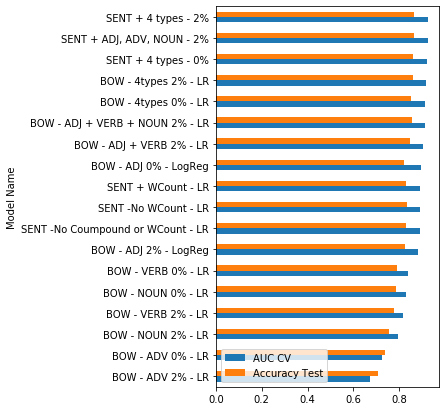

In [69]:
fig, ax = plt.subplots(figsize = (4,7));
resultsDF.set_index('Model Name')[['AUC CV','Accuracy Test']].sort_values(by = 'AUC CV').plot(kind = 'barh', ax = ax);
ax.legend(loc = 'lower left');

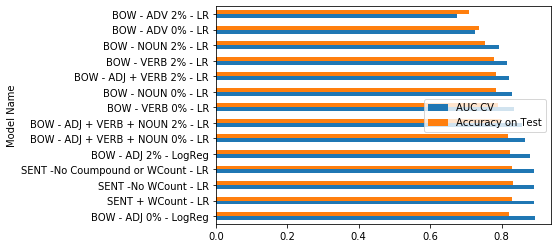

In [37]:
model_resultsumm= {
    'Model Name': [x for x in model_results.keys()],
    'AUC CV': [model_results[x]['AUC CV'] for x in model_results.keys()],
    'Accuracy on Test': [model_results[x]['accuracy test'] for x in model_results.keys()]}

resultsDF = pd.DataFrame(model_resultsumm
                        ).sort_values(by = 'AUC CV', ascending = False
                                     ).set_index('Model Name').plot.barh()


## Model Analysis

When standarising, usually the mean is removed and values are scaled to unit variance. However, when dealing with sparse matrices with a large number of 0 values it is best practice to keep the mean in the values in order to avoid changing all those zeroes to another value. This is because centering them entails building a dense matrix which in common use cases is likely to be too large to fit in memory.

Therefore, in order to save time when training the models, I did not center values. However, I have retrained the best model with centering in order to simplify interpreting its coefficients. 

In [162]:
#'SENT + ADJ, ADV, NOUN, ADV - 2% - Mean True'
#'SENT + 4 types - 2%'
model = model_results['SENT + 4 types - 2%']

In [163]:
model['model']

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=14, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [164]:
print(model['confusion'])
print(model['report'])

[[ 642  285]
 [ 108 1844]]
              precision    recall  f1-score   support

  Bad Review       0.86      0.69      0.77       927
 Good Review       0.87      0.94      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.86      0.82      0.83      2879
weighted avg       0.86      0.86      0.86      2879



In [165]:
predictions = pd.DataFrame()
predictions['Stars'] = reviews.stars.loc[y_test.index]
predictions['Content'] = reviews.content.loc[y_test.index]
predictions['Labels'] = y_test
predictions['Predicted'] = model['model'].predict(Xtest_std_spa)
predictions['Result'] = (y_test == y_test_hat)

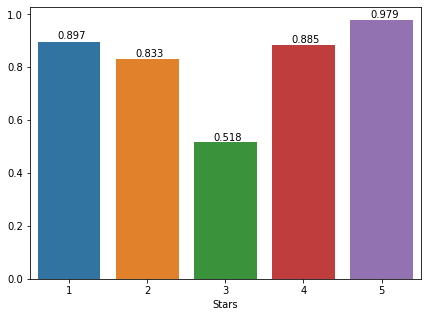

In [166]:
acc_per_star = predictions.groupby('Stars').agg({'Labels':'count','Result':'sum'}
                                  ).apply(lambda x: x['Result']/x['Labels'], axis = 1)
fig, ax = plt.subplots(figsize = (7,5))

sns.barplot(x = acc_per_star.index, y = acc_per_star.values )
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),decimals = 3)), (p.get_x() + 0.25, p.get_height() * 1.01))

In [178]:
for x in range(10):
    print(predictions[(~predictions['Result'])&(predictions.Stars == 3)]['Content'].iloc[x])
    print('')

The Divina is a very large ship with over 4,000 people capacity. We sailed to the Caribbean and made the mistake of going during spring break and the kids came with parents free so half the ship was kids. They were everywhere, in the bars, the restaurants so it made it difficult to find a place to sit. It is a gorgeous ship with Crystal stairs and lots of glitz. The food was very good and the entertainment was first class. We enjoyed a balcony cabin with adjoined our friends cabin so we could share a lot of time together. We will go on this ship again, just not during a spring break.

The Edge has many great qualities and features. It also has a few downsides, at least per our cruise in late November 2019. The stateroom design of 3rd deck cabin (porthole window) is very good-big king size bed that was very comfortable and nice bed linens; the bath is equally terrific-big shower and well laid out- the magnetic door is a big improvement as well avoiding the clicking sound on previous cla

In [168]:
test_indexes = list(Xtest.index)
test_analysis = reviews[['stars','content','stars_grouped']].loc[test_indexes]
test_analysis.head()

,stars,content,stars_grouped
9560,3,"The Divina is a very large ship with over 4,00...",Bad Review
451,5,Fantastic experience perfect fabulous food and...,Good Review
9567,5,What a fantastic experience. I traveled with m...,Good Review
7087,4,I was looking forward to this next gen ship gi...,Good Review
7372,5,"Everything was just excellent - attitude, pass...",Good Review


**Features**

In [169]:
coefficient_df = pd.DataFrame(model['model'].coef_.reshape(-1,1), index = Xtrain_std.columns,columns = ['coefficient']).reset_index()
coefficient_df.columns = ['feature','coefficient']

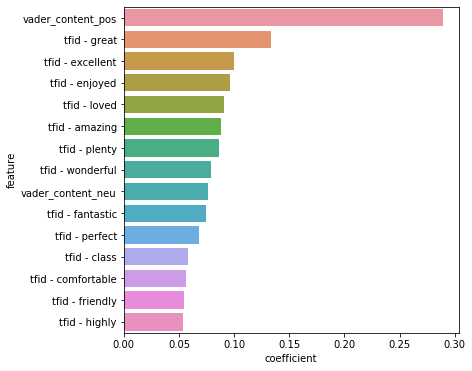

In [170]:
plt.figure(figsize=(6,6));
sns.barplot(x = 'coefficient', y = 'feature', 
            data = coefficient_df.sort_values(by= 'coefficient', ascending=False)[:15]);

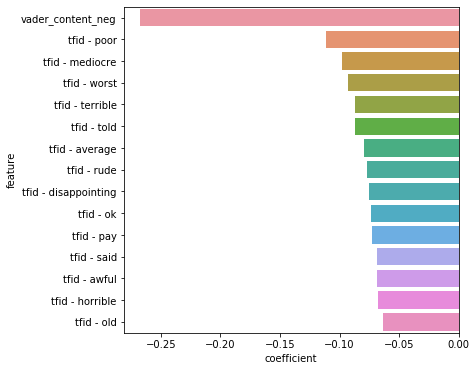

In [171]:
plt.figure(figsize=(6,6));
sns.barplot(x = 'coefficient', y = 'feature',
            data = coefficient_df.sort_values(by= 'coefficient', ascending=True)[:15]);


In [172]:
is_0 = coefficient_df.coefficient.apply(lambda x: np.isclose(x,0))

In [173]:
coefficient_df[coefficient_df.feature == 'vader_content_neu']

,feature,coefficient
1,vader_content_neu,0.076075


## ROC

In [220]:
probabilities = pd.DataFrame(model.predict_proba(Xtest_std_spa), columns = ['Bad','Good'])

prob = []
tp = []
fn = []
fp = []
tn = []
confu = []
    
for p in np.linspace(0,1,21):
    y_hat = probabilities.Bad.apply(lambda x : 'Bad Review' if x>p else 'Good Review')
    conf = confusion_matrix(y_test,y_hat)
    prob.append(p)
    tp.append(conf[0][0])
    fn.append(conf[0][1])
    fp.append(conf[1][0])
    tn.append(conf[1][1])
    confu.append(conf)

thresholds = pd.DataFrame({'tp':tp,'fn':fn,'fp':fp,'tn':tn},index = prob)
thresholds['True_Positive_Rate'] = thresholds.apply(lambda x: x['tp']/(x['fn']+x['tp']),axis = 1)
thresholds['False_Positive_Rate'] = thresholds.apply(lambda x: x['fp']/(x['tn']+x['fp']),axis = 1)
thresholds['Precision'] = thresholds.apply(lambda x: x['tp']/(x['tp']+x['fp']),axis = 1)

In [213]:
from ipywidgets import *

from pprint import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, auc, f1_score,
                             precision_recall_curve, average_precision_score)

In [223]:
ratio = 0.35000000000000003
npRatio = int(np.round(ratio,decimals = 2)*100)
npRatio

35

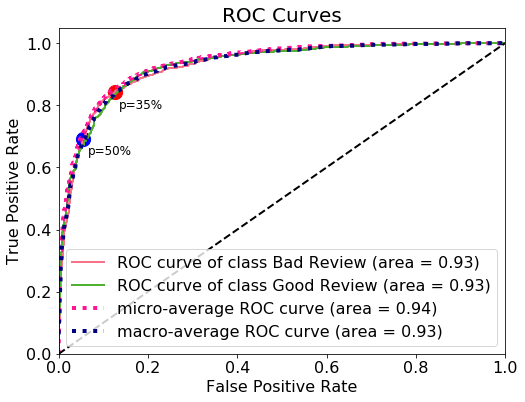

In [224]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

skplt.metrics.plot_roc(y_test, model.predict_proba(Xtest_std_spa), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)

plt.scatter(thresholds.loc[0.5,'False_Positive_Rate'], thresholds.loc[0.5,'True_Positive_Rate'], s = 200,c = 'blue')
plt.scatter(thresholds.loc[ratio,'False_Positive_Rate'], thresholds.loc[ratio,'True_Positive_Rate'], s = 200, c = 'red')

plt.text(thresholds.loc[ratio,'False_Positive_Rate']+0.01, thresholds.loc[ratio,'True_Positive_Rate']-0.05,
         'p={}%'.format(npRatio),
         fontsize=12)
plt.text(thresholds.loc[0.5,'False_Positive_Rate']+0.01, thresholds.loc[0.5,'True_Positive_Rate']-0.05, 
         'p=50%',
         fontsize=12)

plt.show()



In [225]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

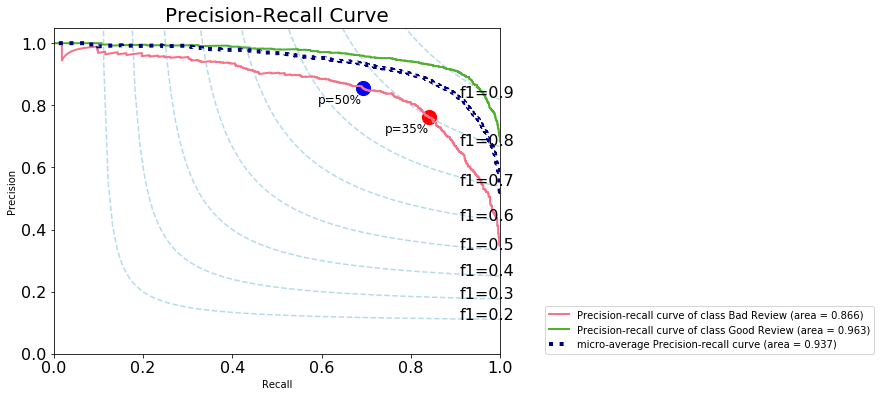

In [226]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model.predict_proba(Xtest_std_spa),
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])

plt.scatter(thresholds.loc[0.5,'True_Positive_Rate'], thresholds.loc[0.5,'Precision'], s = 200,c = 'blue')
plt.scatter(thresholds.loc[ratio,'True_Positive_Rate'], thresholds.loc[ratio,'Precision'], s = 200, c = 'red')

plt.text(thresholds.loc[ratio,'True_Positive_Rate']-0.1, thresholds.loc[ratio,'Precision']-0.05,
         'p={}%'.format(npRatio), fontsize=12)
plt.text(thresholds.loc[0.5,'True_Positive_Rate']-0.1, thresholds.loc[0.5,'Precision']-0.05, 'p=50%', fontsize=12)

plt.show()


In [227]:
for x,y in zip(prob,confu):
    print(x)
    print(y)

0.0
[[ 927    0]
 [1952    0]]
0.05
[[ 925    2]
 [1653  299]]
0.1
[[ 918    9]
 [1164  788]]
0.15000000000000002
[[ 900   27]
 [ 830 1122]]
0.2
[[ 866   61]
 [ 591 1361]]
0.25
[[ 837   90]
 [ 432 1520]]
0.30000000000000004
[[ 810  117]
 [ 323 1629]]
0.35000000000000003
[[ 780  147]
 [ 244 1708]]
0.4
[[ 742  185]
 [ 176 1776]]
0.45
[[ 698  229]
 [ 135 1817]]
0.5
[[ 642  285]
 [ 108 1844]]
0.55
[[ 581  346]
 [  81 1871]]
0.6000000000000001
[[ 513  414]
 [  60 1892]]
0.65
[[ 453  474]
 [  49 1903]]
0.7000000000000001
[[ 382  545]
 [  30 1922]]
0.75
[[ 303  624]
 [  19 1933]]
0.8
[[ 246  681]
 [  12 1940]]
0.8500000000000001
[[ 165  762]
 [   6 1946]]
0.9
[[  87  840]
 [   1 1951]]
0.9500000000000001
[[  18  909]
 [   1 1951]]
1.0
[[   0  927]
 [   0 1952]]


## Decision Trees

In [198]:
# Decision Tree Grid Dictionary
dtree_dict = {
    'max_depth':[3,4,5,6,7,8,9,10],
    'criterion':['gini','entropy'],
    ''}

#Decision Tree regression parameter dictionaty
dtree_grid = grid(
    'Combined - DecisionTreeClassifier',DecisionTreeClassifier(random_state = random_state),dtree_dict, 
    Xtrain_std,ytrain,Xtest_std,ytest,scoring = 'roc_auc')

SyntaxError: invalid syntax (<ipython-input-198-6dc2deeb55da>, line 5)

In [231]:
y_test
y_hat2 = probabilities.Bad.apply(lambda x : 'Bad Review' if x>0.35 else 'Good Review')
print(classification_report(y_test,y_hat2))

              precision    recall  f1-score   support

  Bad Review       0.76      0.84      0.80       927
 Good Review       0.92      0.88      0.90      1952

    accuracy                           0.86      2879
   macro avg       0.84      0.86      0.85      2879
weighted avg       0.87      0.86      0.87      2879

